In [1]:
cd ../../

/Users/in-divye.singh/Documents/Projects/MIC_predictor


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from notebooks.pcm.utils import ZScalesExtractor

In [4]:
mic = pd.read_csv("data/raw/MIC_pIC50_values.csv")

In [5]:
seq = pd.read_csv("data/raw/peptide_target_seq.csv")

In [6]:
seq = seq.merge(mic, on='Sequence')

In [7]:
zscale = ZScalesExtractor("data/raw/z_scales_5.csv")

In [8]:
zscales_features = zscale.transform(seq)

In [9]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
seq.shape

(50, 7)

In [23]:
def optimise_pls_cv(X, y, n_comp):
    # Define PLS object
    pls = PLSRegression(n_components=n_comp)

    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=50)

    # Calculate scores
    r2 = r2_score(y, y_cv)
    mse = mean_squared_error(y, y_cv)
    mape = mean_absolute_percentage_error(y, y_cv)
    rpd = y.std()/np.sqrt(mse)
    
    return (y_cv, r2, mse, mape, rpd)

In [31]:
r2s = []
mses = []
mapes = []
rpds = []
xticks = np.arange(1, 28)#zscales_features.shape[1]-1)
for n_comp in xticks:
    y_cv, r2, mse, mape, rpd = optimise_pls_cv(zscales_features, seq['pIC50'], n_comp)
    r2s.append(r2)
    mses.append(mse)
    mapes.append(mape)
    rpds.append(rpd)

In [25]:
def plot_metrics(vals, ylabel, objective):
    with plt.style.context('ggplot'):
        plt.plot(xticks, np.array(vals), '-v', color='blue', mfc='blue')
        if objective=='min':
            idx = np.argmin(vals)
        else:
            idx = np.argmax(vals)
        plt.plot(xticks[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel)
        plt.title('PLS')

    plt.show()

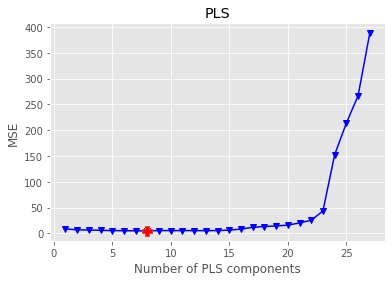

In [32]:
plot_metrics(mses, 'MSE', 'min')

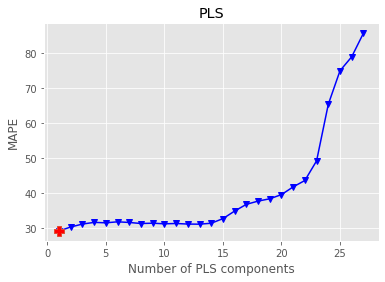

In [33]:
plot_metrics(mapes, 'MAPE', 'min')

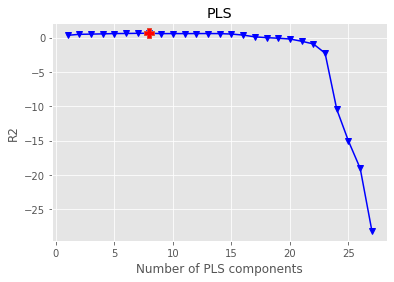

In [34]:
plot_metrics(r2s, 'R2', 'max')

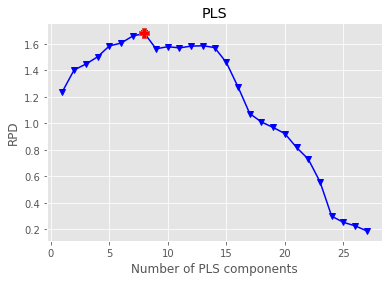

In [35]:
plot_metrics(rpds, 'RPD', 'max')

In [36]:
pd.DataFrame(list(zip(mses, mapes, r2s, rpds)), columns=['MSE', 'MAPE', 'R2', 'RPD'])

,MSE,MAPE,R2,RPD
0,8.837593,29.220479,0.335585,1.239274
1,6.899716,30.337519,0.481276,1.402551
2,6.487110,31.176660,0.512296,1.446467
3,6.021734,31.652963,0.547283,1.501321
4,5.414911,31.526978,0.592904,1.583210
5,5.266057,31.816216,0.604095,1.605430
6,4.938348,31.628558,0.628732,1.657843
7,4.810969,31.328854,0.638309,1.679647
8,5.562675,31.422025,0.581795,1.562041
9,5.450364,31.246639,0.590239,1.578053


In [ ]:
seq